In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random
import keras_tuner as kt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tensorflow import math
from sklearn.tree import DecisionTreeClassifier

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
# read csv file
insurance_df = pd.read_csv("Insurance_claims.csv")
# insurance_df.head()
insurance_df = insurance_df.drop(
    ["ReferenceId", "PolicyholderNumber", "InsurerNotes"], axis=1
)
# these are unique values which should be dropped and column about postcode and date will be dropped later
# we need to find those repeated values and set them into 1, others into 0(including the missing value)
mask = insurance_df["FirstPartyVehicleNumber"].duplicated()
insurance_df.loc[mask, "FirstPartyVehicleNumber"] = 1
insurance_df.loc[~mask, "FirstPartyVehicleNumber"] = 0


# check if there is thirdpartyvehicle, yes -> 1, no -> 0
insurance_df["ThirdPartyVehicleNumber"].fillna(0)
insurance_df["ThirdPartyVehicleNumber"] = insurance_df["ThirdPartyVehicleNumber"].apply(
    lambda x: 1 if x > 0 else 0
)
insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(
    insurance_df["FirstPolicySubscriptionDate"]
)

# calculate the number of days between the two dates
insurance_df["days_between"] = insurance_df.apply(
    lambda row: (row["LossDate"] - row["FirstPolicySubscriptionDate"]).days, axis=1
)
insurance_df = insurance_df.drop(["LossDate", "FirstPolicySubscriptionDate", "ConnectionBetweenParties"], axis=1)
# check the two postcodes
def compare_digits(x, y):
    x_len = len(str(x))
    y_len = len(str(y))
    if x_len == y_len:
        if x_len == 5:
            return str(x)[:2] == str(y)[:2]
        elif x_len == 4:
            return str(x)[0] == str(y)[0]
        else:
            return False
    else:
        return False


# check if the loss place is in the same district of the holder's place
insurance_df["IfinSameArea"] = insurance_df.apply(
    lambda row: 1
    if compare_digits(row["LossPostCode"], row["PolicyHolderPostCode"])
    else 0,
    axis=1,
)

insurance_df = insurance_df.drop(["LossPostCode", "PolicyHolderPostCode"], axis=1)
# set these columns to dummies
insurance_df = pd.get_dummies(
    insurance_df,
    columns=[
        "PolicyholderOccupation",
        "ClaimCause",
        "ClaimInvolvedCovers",
        "FirstPartyVehicleType",
    ],
)

# check the two postcodes
def jud(x):
    if x == "TotalLoss":
        return 2
    elif x == "Medium":
        return 1
    else:
        return 0


insurance_df["DamageImportance"] = insurance_df["DamageImportance"].fillna(0)
insurance_df["DamageImportance"] = insurance_df["DamageImportance"].apply(
    lambda row: jud(row)
)

mean_v_fp = insurance_df["FpVehicleAgeMonths"].mean()
insurance_df["FpVehicleAgeMonths"] = insurance_df["FpVehicleAgeMonths"].fillna(
    value=mean_v_fp
)

insurance_df["LossHour"] = insurance_df["LossHour"].fillna(
    insurance_df["LossHour"].mean()
)
mean_v_po = insurance_df["PolicyHolderAge"].mean()
insurance_df["PolicyHolderAge"] = insurance_df["PolicyHolderAge"].fillna(mean_v_po)

In [7]:
y = insurance_df["Fraud"]  # creating the dependent variable
X = insurance_df.drop(columns=["Fraud"])


X_train, X_other, Y_train, Y_other = train_test_split(
    X, y, train_size=0.7, random_state=111
)

X_test, X_valid, Y_test, Y_valid = train_test_split(
    X_other, Y_other, test_size=0.5, random_state=112
)

X_train.shape, Y_train.shape, X_test.shape

((8070, 116), (8070,), (1730, 116))

## Standardizing input data 

In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## This section includes 3 methods: 

    1. opt_threshold() calculates the optimal threshold for dealing with the network outputs based on "sigmiod" activetion function.
       The optimal threshold will be the highest f1 score of Y_test and y_pred_threshold.

    2. show_predicted_result() shows the hit rate, detection rate and other relevant results.

    3. create_plot() shows the model loss, accuracy, validation loss and validation accuracy.

In [45]:
def opt_threshold(model):
    # Make predictions on the test set
    y_pred = model.predict(X_valid_scaled)

    # Calculate the F1 score for different threshold values
    f1_scores = []
    thresholds = np.arange(0.0, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_thresh = tf.keras.backend.cast(y_pred > threshold, 'float32')
        f1 = f1_score(Y_valid, y_pred_thresh)
        f1_scores.append(f1)

    # Select the threshold with the highest F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    return optimal_threshold


def show_predicted_result(model, data):
    y_pred = model.predict(data)
    y_pred = y_pred.ravel()

    mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
    print("Mean square error: ", mse)

    opt_thresh = opt_threshold(model) 

    y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

    hits = sum(Y_test & y_pred)

    hit_rate = hits / np.sum(y_pred)
    detection_rate = np.sum(y_pred) / len(y_pred)


    print("Threshold-------------------------:", opt_thresh)
    print("Number of data in testset:--------:", len(y_pred))
    print("Number of predicted frauds--------:", np.sum(y_pred))
    print("Total number of frauds in testset-:", np.sum(Y_test))
    print("Number of predicted frauds hit----:", hits)
    print("Hit rate--------------------------:", hit_rate)
    print("Detection rate--------------------:", detection_rate)
    

def create_plot(log):
    plt.plot(log.history["accuracy"], label="training accuracy", color="red")
    plt.plot(log.history["loss"], label="training loss", color="darkgreen")
    plt.plot(
        log.history["val_accuracy"],
        label="validation accuracy",
        color="grey",
    )
    plt.plot(log.history["val_loss"], label="validation loss", color="darkblue")
    plt.legend()
    plt.show()

## Question 4: Building a decision tree model

    • A default and pruned decision trees are given and their hit rates are lower than the neuron network's one
      when having the similar detection rates.

    1. Default decision tree
            Detection rate: 0.0116, Hit rate: 0.15
  
    2. Neuron network
            Detection rate: 0.0133, Hit rate: 0.174

In [67]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
Pred = dtc.predict(X_test)
hits1 = sum(Y_test & Pred)

hit_rate1 = hits1 / Pred.sum()
detection_rate1 = Pred.sum()/ len(Y_test)

print("Hit rate:", hit_rate1)
print("Detection rate:", detection_rate1)

Hit rate: 0.15
Detection rate: 0.011560693641618497


In [8]:
# Create a list of tuples with feature names and their importance scores
feature_importances = [(feature, importance) for feature, importance in zip(dtc.feature_names_in_, dtc.feature_importances_)]

# Sort the list of feature importances in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the first 10 most important features
for feature, importance in feature_importances[:30]:
    print(f"{feature}: {importance:.4f}")

days_between: 0.2238
FpVehicleAgeMonths: 0.1454
ClaimAmount: 0.1422
PolicyHolderAge: 0.1058
LossHour: 0.1040
DamageImportance: 0.0539
NumberOfPoliciesOfPolicyholder: 0.0484
ClaimCause_LossOfControl: 0.0245
ClaimInvolvedCovers_ActLiability Fire ThirdParty: 0.0214
ClaimCause_WindscreenDamage: 0.0185
ConnectionBetweenParties_SameAddress: 0.0132
EasinessToStage: 0.0119
ClaimCause_AccidentWithUnidentifiedThirdParty: 0.0108
ClaimCause_Flood: 0.0101
ClaimInvolvedCovers_ActLiability Fire: 0.0094
FirstPartyLiability: 0.0088
FirstPartyVehicleType_Car: 0.0084
PolicyholderOccupation_Employee: 0.0079
ClaimWihoutIdentifiedThirdParty: 0.0058
ClaimCause_Hail: 0.0053
ClaimInvolvedCovers_ThirdParty: 0.0053
ClaimInvolvedCovers_Windscreen ActLiability: 0.0045
ClaimCause_AccidentOrCollision: 0.0040
ClaimInvolvedCovers_MaterialDamages ActLiability MedicalCare: 0.0021
ConnectionBetweenParties_SamePolice: 0.0017
ClaimCause_TotalTheft: 0.0012
FirstPartyVehicleNumber: 0.0012
ThirdPartyVehicleNumber: 0.0008
Poli

## Question 5: Building a deep neuron network

    We first create a hyperparameter searching space for Hyperband tuner to train and search the best model

    • 5 hyperparameters are tuned and 3 optimizers as well
    • Leaky relu is used to capture more negative inputs with alpha = 0.2, improving the "dying relu" problem
    • Batch normalisation layers help the network to converge faster
    • 10 metrics will be output by the model
     

In [26]:
def train_model(hp):

    # 5 hyperparameters to tune
    n_hiddens = hp.Int("n_hiddens", min_value=2, max_value=24, step=1)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=512, step=8)
    dropout_rate = hp.Float("dropout_rate", min_value=0.01, max_value=1, step=0.01)
    learning_rate = hp.Float(
        "learning_rate", min_value=0.001, max_value=0.1, sampling="log"
    )
    regulizer = hp.Float("regulizer", min_value=0.1, max_value = 1)
    
    model = tf.keras.Sequential(
        [tf.keras.layers.Flatten(input_shape=(116, 1))]
    )

    for _ in range(n_hiddens):
        
        model.add(
            tf.keras.layers.Dense(
                n_neurons,
                activation= hp.Choice("activation", values=["tanh", "relu", "leaky_relu"])
                )
        )
        tf.keras.layers.BatchNormalization(),
        tf.keras.regularizers.L1(regulizer)
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    METRICS = [
      tf.keras.metrics.MeanSquaredError(name='mse'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(
        # optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
        optimizer=optimizer, loss='binary_crossentropy', 
                  metrics=METRICS
    )

    return model

## Calculate a weight ratio for frauds and non frauds data

    • Adding more weights on the fraud data as they are only 1% of the total dataset
    
    • The purpose of doing this is to let the neuron network pays more attention on the fraud data in the training process

In [20]:
neg, pos = np.bincount(insurance_df['Fraud'])
total = neg + pos
print('Total: {}\nFrauds: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total: 11530
Frauds: 115 (1.00% of total)

Weight for class 0: 0.51
Weight for class 1: 50.13


## Hyperband tuner 

    • The tuner objective is to find the best "val_accuracy", despite it is not the task goal
    • A better model "best_hb_model" was saved after several model fittings for comparing with result from decision tree

In [37]:
hyperband_tuner = kt.Hyperband(
    train_model,
    # objective=kt.Objective("rmse", direction="min"),
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory="logs",
    project_name="hb_tuner",
    
)

hyperband_tuner.search(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid))
best_hps = hyperband_tuner.get_best_hyperparameters()[0]
best_hb_model = hyperband_tuner.hypermodel.build(best_hps)

INFO:tensorflow:Reloading Oracle from existing project logs/hb_tuner/oracle.json
INFO:tensorflow:Reloading Tuner from logs/hb_tuner/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [40]:
# set a early stopping for saving time during model fitting
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
    mode='max'
)  

# fitting the model 
log = best_hb_model.fit(
    X_train_scaled,
    Y_train,
    epochs=50,
    batch_size=1024,
    validation_data=(X_valid_scaled, Y_valid),
    class_weight = class_weight
)

Epoch 1/50
8/8 [==============================] - 0s 39ms/step - loss: 0.2664 - mse: 0.1318 - tp: 84.0000 - fp: 1650.0000 - tn: 6335.0000 - fn: 1.0000 - accuracy: 0.7954 - precision: 0.0484 - recall: 0.9882 - auc: 0.9457 - prc: 0.1418 - val_loss: 0.2483 - val_mse: 0.0878 - val_tp: 11.0000 - val_fp: 222.0000 - val_tn: 1493.0000 - val_fn: 4.0000 - val_accuracy: 0.8694 - val_precision: 0.0472 - val_recall: 0.7333 - val_auc: 0.9306 - val_prc: 0.1432
Epoch 2/50
8/8 [==============================] - 0s 37ms/step - loss: 0.3333 - mse: 0.0987 - tp: 77.0000 - fp: 1192.0000 - tn: 6793.0000 - fn: 8.0000 - accuracy: 0.8513 - precision: 0.0607 - recall: 0.9059 - auc: 0.9374 - prc: 0.1355 - val_loss: 0.4874 - val_mse: 0.1348 - val_tp: 10.0000 - val_fp: 275.0000 - val_tn: 1440.0000 - val_fn: 5.0000 - val_accuracy: 0.8382 - val_precision: 0.0351 - val_recall: 0.6667 - val_auc: 0.8696 - val_prc: 0.0674
Epoch 3/50
8/8 [==============================] - 0s 34ms/step - loss: 0.3370 - mse: 0.1516 - tp: 82

In [46]:
show_predicted_result(best_hb_model, X_test_scaled)

55/55 [==============================] - 0s 3ms/step
Mean square error:  0.09754920464238893
55/55 [==============================] - 0s 3ms/step
Threshold-------------------------: 0.9400000000000001
Number of data in testset:--------: 1730
Number of predicted frauds--------: 23
Total number of frauds in testset-: 15
Number of predicted frauds hit----: 4
Hit rate--------------------------: 0.17391304347826086
Detection rate--------------------: 0.013294797687861272


## Saving the best model above for model comparison of decison tree and future uses

    • Only need to run once

## Loading the saved model to predict new data


In [50]:
tf.keras.models.save_model(best_hb_model, "finally_model.h1")

final_model = tf.keras.models.load_model("finally_model.h1")
final_model.load_weights("finally_model.h1")

show_predicted_result(final_model, X_test_scaled)

INFO:tensorflow:Assets written to: finally_model.h1/assets
17/55 [========>.....................] - ETA: 0s

2023-03-07 22:56:55.177100: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open finally_model.h1: FAILED_PRECONDITION: finally_model.h1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-03-07 22:56:55.274192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 0s 4ms/step
Mean square error:  0.09754920464238893
55/55 [==============================] - 0s 3ms/step
Threshold-------------------------: 0.9400000000000001
Number of data in testset:--------: 1730
Number of predicted frauds--------: 23
Total number of frauds in testset-: 15
Number of predicted frauds hit----: 4
Hit rate--------------------------: 0.17391304347826086
Detection rate--------------------: 0.013294797687861272


In [281]:
temp_model = final_model

val_false_pos = []
val_true_pos = []
true_pos = []
false_pos = []
precision = []
val_accuracy = []
accuracy = []
val_loss = []
loss = []

for batch in range(128, 2560, 128):

# # fitting the model 
    log = temp_model.fit(
        X_train,
        Y_train,
        epochs=50,
        batch_size=batch,
        validation_data=(X_valid, Y_valid),
        # callbacks=[early_stopping_cb],
        class_weight = class_weight
    )

    false_pos.append(np.mean(log.history["fp"]))
    true_pos.append(np.mean(log.history["tp"]))
    val_false_pos.append(np.mean(log.history["val_fp"]))
    val_true_pos.append(np.mean(log.history["val_tp"]))
    val_accuracy.append(np.mean(log.history["val_accuracy"]))
    accuracy.append(np.mean(log.history["accuracy"]))
    val_loss.append(np.mean(log.history["val_loss"]))
    loss.append(np.mean(log.history["loss"]))


Epoch 1/50


2023-03-07 03:42:58.893424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 1.4951 - mse: 0.0822 - tp: 70.0000 - fp: 873.0000 - tn: 7112.0000 - fn: 15.0000 - accuracy: 0.8900 - precision: 0.0742 - recall: 0.8235 - auc: 0.9002 - prc: 0.1265

2023-03-07 03:43:38.871672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 51s 596ms/step - loss: 1.4951 - mse: 0.0822 - tp: 70.0000 - fp: 873.0000 - tn: 7112.0000 - fn: 15.0000 - accuracy: 0.8900 - precision: 0.0742 - recall: 0.8235 - auc: 0.9002 - prc: 0.1265 - val_loss: 0.2734 - val_mse: 0.0791 - val_tp: 3.0000 - val_fp: 103.0000 - val_tn: 1612.0000 - val_fn: 12.0000 - val_accuracy: 0.9335 - val_precision: 0.0283 - val_recall: 0.2000 - val_auc: 0.6483 - val_prc: 0.0140
Epoch 2/50
64/64 [==============================] - 6s 95ms/step - loss: 0.5102 - mse: 0.1203 - tp: 71.0000 - fp: 1398.0000 - tn: 6587.0000 - fn: 14.0000 - accuracy: 0.8250 - precision: 0.0483 - recall: 0.8353 - auc: 0.9156 - prc: 0.1178 - val_loss: 1.2713 - val_mse: 0.1744 - val_tp: 12.0000 - val_fp: 342.0000 - val_tn: 1373.0000 - val_fn: 3.0000 - val_accuracy: 0.8006 - val_precision: 0.0339 - val_recall: 0.8000 - val_auc: 0.8294 - val_prc: 0.0406
Epoch 3/50
64/64 [==============================] - 5s 81ms/step - loss: 0.5926 - mse: 0.1200 - tp: 71.0

Text(0.5, 0, 'Batch Size')

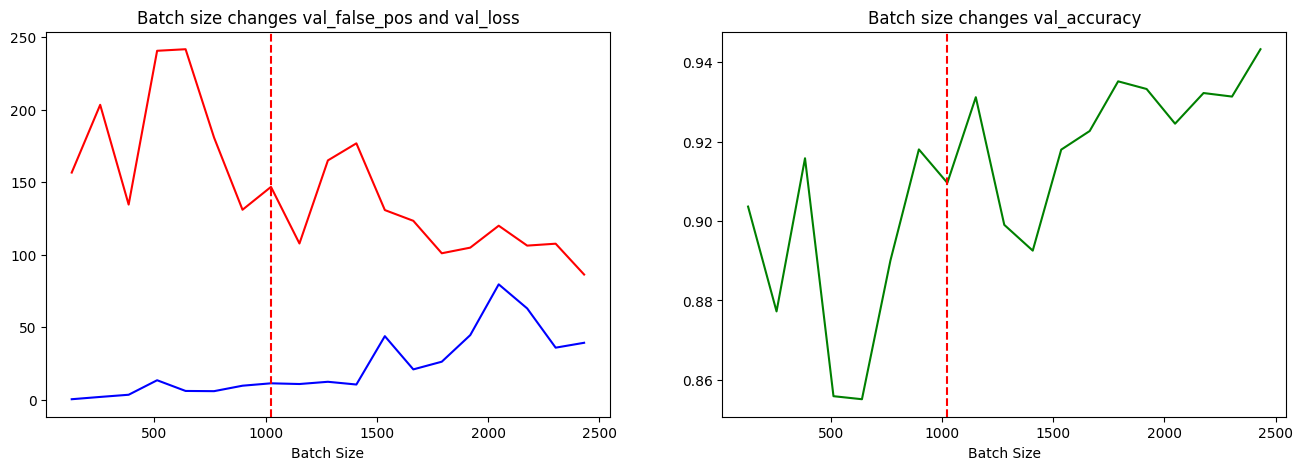

In [283]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

x = [i for i in range(128, 2560, 128)]

# Plot the first subplot in the first column
axes[0].plot(x, val_false_pos, color='red')
axes[0].plot(x, val_loss, color='blue')
# Draw a vertical line at x=5
axes[0].axvline(x=1024, color='red', linestyle='--')
axes[0].set_title('Batch size changes val_false_pos and val_loss')
axes[0].set_xlabel("Batch Size")


# Plot the second subplot in the second column
axes[1].plot(x, val_accuracy, color='green')
axes[1].axvline(x=1024, color='red', linestyle='--')
axes[1].set_title('Batch size changes val_accuracy')
axes[1].set_xlabel("Batch Size")


## Result of the network:
     The hit rate and detection rate of the network are all higher than the decision 

    1. Default decision tree
            Detection rate: 0.0104, Hit rate: 0.1111
    
    2. Pruned decision tree
            Detection rate: 0.0110, Hit rate: 0.1579

    3. Neuron network
            Detection rate: 0.0116, Hit rate: 0.2500

## Question 6

In [ ]:
# Divide fraudulent and non-fraudulent observations
df_frau = insurance_df.loc[insurance_df["Fraud"]==1]
df_nofr = insurance_df.loc[insurance_df["Fraud"]==0]
# Build X set and y set
X_frau = df_frau.drop(columns = ["Fraud"])
Y_frau = df_frau["Fraud"]
X_nofr = df_nofr.drop(columns = ["Fraud"])
Y_nofr = df_nofr["Fraud"]
print("X with fraud:", X_frau.shape)
print("X without fraud:", X_nofr.shape)
print("proportion:", X_frau.shape[0]/X_nofr.shape[0])

# Split Train & Other dataset without fraudulent observations
X_train, X_other, Y_train, Y_other = train_test_split(X_nofr, Y_nofr, test_size=0.4, random_state = 111)
print("Train:",X_train.shape)
print("Other:",X_other.shape)
# Split Vali & Test dataset without fraudulent observations
X_test_n, X_vali_n, Y_test_n, Y_vali_n = train_test_split(X_other, Y_other, test_size=0.3, random_state = 111)
print("Test_n:",X_test_n.shape)
print("Vali_n:", X_vali_n.shape)

# Split fraudulent observations equally
X_test_y, X_vali_y, Y_test_y, Y_vali_y = train_test_split(X_frau, Y_frau, test_size=0.3, random_state = 111)
print("Test_y:",X_test_y.shape)
print("Vali_y:", X_vali_y.shape)

# Concate observations with / without fraudulent observations in test & vali dataset
X_test = pd.concat([X_test_n, X_test_y], axis = 0, ignore_index = True)
Y_test = pd.concat([Y_test_n, Y_test_y], axis = 0, ignore_index = True)
X_vali = pd.concat([X_vali_n, X_vali_y], axis = 0, ignore_index = True)
Y_vali = pd.concat([Y_vali_n, Y_vali_y], axis = 0, ignore_index = True)

print("Test:",X_test.shape)
print("Vali:", X_vali.shape)

In [ ]:
hyperband_tuner = kt.Hyperband(
    train_model,
    # objective=kt.Objective("rmse", direction="min"),
    objective='val_accuracy',
    max_epochs=30,
    factor=2,
    directory="logs",
    project_name="kt_tutorial_2",
)

hyperband_tuner.search(X_train, Y_train, validation_data=(X_vali, Y_vali))
best_hps = hyperband_tuner.get_best_hyperparameters()[0]
best_hb_model = hyperband_tuner.hypermodel.build(best_hps)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
)  

log = best_hb_model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=2048,
    validation_data=(X_vali, Y_vali),
    callbacks=[early_stopping_cb],
    class_weight = class_weight
)
create_plot(log)

In [ ]:
y_pred = best_hb_model.predict(X_test)
y_pred = y_pred.ravel()

mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
print("Mean square error: ", mse)

opt_thresh = opt_threshold(best_hb_model) 

y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

hits = sum(Y_test & y_pred)

hit_rate = hits / np.sum(y_pred)
detection_rate = np.sum(y_pred) / len(y_pred)

print("Threshold-------------------------:", opt_thresh)
print("Number of predicted frauds--------:", np.sum(y_pred))
print("Total number of frauds in testset-:", np.sum(Y_test))
print("Number of predicted frauds hit----:", hits)
print("Hit rate--------------------------:", hit_rate)
print("Detection rate--------------------:", detection_rate)

In [ ]:
# make X_train, y_train, X_valid, y_valid
mask_value = -9999.99
epochs = 200


class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        hp_lstm_units = hp.Int("units", min_value=16, max_value=128, step=16)
        hp_dropout_rate = hp.Float("drop_out_rate", min_value=0, max_value=0.6)
        hp_recurrent_dropout_rate = hp.Float(
            "recurrent_dropout_rate", min_value=0, max_value=0.6
        )
        hp_initial_learning_rate = hp.Float(
            "initial_learning_rate", min_value=1e-3, max_value=1e-1, sampling="log"
        )
        hp_decay = hp.Int("decay", min_value=10, max_value=100, step=10)

        # model
        model = tf.keras.Sequential()

        model.add(
            tf.keras.layers.Masking(
                mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])
            )
        )
        model.add(
            tf.keras.layers.LSTM(
                hp_lstm_units,
                dropout=hp_dropout_rate,
                recurrent_dropout=hp_recurrent_dropout_rate,
            )
        )
        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=tf.keras.optimizers.SGD(
                learning_rate=hp_initial_learning_rate, decay=hp_decay
            ),
            metrics=[
                # tf.keras.metrics.TruePositives(name='tp'),
                # tf.keras.metrics.FalsePositives(name='fp'),
                # tf.keras.metrics.TrueNegatives(name='tn'),
                # tf.keras.metrics.FalseNegatives(name='fn'),
                # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                # tf.keras.metrics.Precision(name='precision'),
                # tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name="auc"),
            ],
        )
        return model

    def fit(self, hp):
        hp_batch_size = hp.Int("batch_size", min_value=8, max_value=128, step=8)
        return model.fit(*args, batch_size=hp_batch_size, **kwargs)


tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective=kt.Objective("val_auc", direction="max"),
    overwrite=True,
    max_trials=100,
    directory="MyDirectory",
    project_name="MyProject",
)

tuner.search(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid))